#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션①
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.


### (2) 미션②  
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* 1) Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다. 
* 2) Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다. 
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 targe을 추가하여 EDA를 수행해 봅시다.


## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 필요하다고 판단되는 라이브러리를 추가하세요.





* 변수 중요도 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 : 
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 : 
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [2]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용 데이터셋
    * feature.csv : feature 이름을 계층구조로 정리한 데이터  
 <br/>
    

* 세부 요구사항
    - 전체 데이터 'data01_train.csv' 를 불러와 'data' 변수에 저장합니다.
    - 센서 그룹 데이터 'feature.csv' 를 불러와 'features' 변수에 저장합니다.

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
data = pd.read_csv('/content/drive/MyDrive/KT_aivle/미니프로젝트_5차/data01_train.csv')
features = pd.read_csv('/content/drive/MyDrive/KT_aivle/미니프로젝트_5차/features.csv')

In [5]:
data = data.drop('subject', axis=1)

In [6]:
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [7]:
features.head()

,sensor,agg,axis,feature_name
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z
3,tBodyAcc,std(),X,tBodyAcc-std()-X
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y


## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


In [9]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sensor        561 non-null    object
 1   agg           561 non-null    object
 2   axis          436 non-null    object
 3   feature_name  561 non-null    object
dtypes: object(4)
memory usage: 17.7+ KB


In [10]:
features.describe()

,sensor,agg,axis,feature_name
count,561,561,436,561
unique,18,27,62,533
top,fBodyGyro,bandsEnergy(),X,"fBodyGyro-bandsEnergy()-25,32"
freq,79,126,76,3


### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [11]:
data['Activity'].value_counts()

LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: Activity, dtype: int64

In [12]:
data['Activity'].value_counts() / len(data)

LAYING                0.189594
STANDING              0.184833
SITTING               0.175480
WALKING               0.169699
WALKING_UPSTAIRS      0.145894
WALKING_DOWNSTAIRS    0.134501
Name: Activity, dtype: float64

<Axes: xlabel='Activity', ylabel='count'>

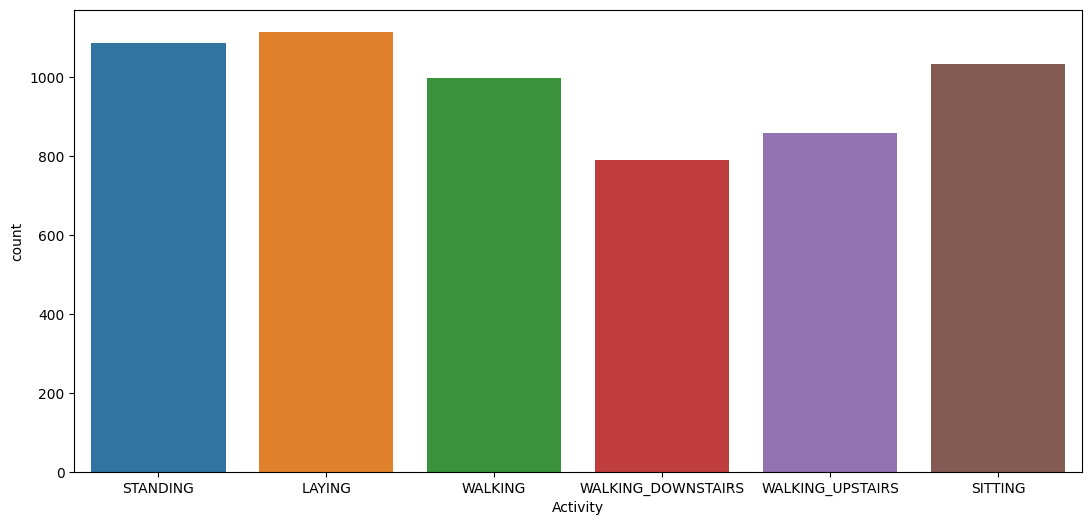

In [13]:
plt.figure(figsize=(13,6))
sns.countplot(x='Activity', data=data)

### (3) 센서 그룹 데이터: features

* **세부 요구사항**
    - feature 이름에 대한 계층 구조별로 변수의 수를 카운트 해 봅시다.
        - sensor 별 변수의 개수
        - agg(regation) 별 변수의 개수
        - axis 별 변수의 개수

In [14]:
features['sensor'].value_counts()

fBodyGyro               79
fBodyAcc                79
fBodyAccJerk            79
tBodyAcc                40
tBodyAccJerk            40
tBodyGyro               40
tBodyGyroJerk           40
tGravityAcc             40
fBodyBodyGyroJerkMag    13
fBodyBodyGyroMag        13
fBodyBodyAccJerkMag     13
fBodyAccMag             13
tBodyGyroJerkMag        13
tBodyGyroMag            13
tBodyAccJerkMag         13
tGravityAccMag          13
tBodyAccMag             13
angle                    7
Name: sensor, dtype: int64

In [15]:
features['agg'].value_counts()

bandsEnergy()        126
arCoeff()             60
mean()                33
mad()                 33
max()                 33
min()                 33
energy()              33
iqr()                 33
entropy()             33
std()                 33
sma()                 17
correlation()         15
meanFreq()            13
kurtosis()            13
skewness()            13
maxInds               13
arCoeff()3             5
arCoeff()4             5
arCoeff()2             5
arCoeff()1             5
tBodyAccMean           1
tBodyAccJerkMean       1
tBodyGyroMean          1
tBodyGyroJerkMean      1
X                      1
Y                      1
Z                      1
Name: agg, dtype: int64

In [16]:
features['axis'].value_counts()

X              76
Y              76
Z              76
gravityMean     6
X,2             5
               ..
25,32.1         2
17,24.1         2
1,8.1           2
9,16.1          2
gravity         1
Name: axis, Length: 62, dtype: int64

## 3.데이터 분석 : 미션1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다. 
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

In [17]:
y = data['Activity']
x = data.drop('Activity', axis=1)

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(x,y, test_size=0.25, random_state=1)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((4410, 561), (1471, 561), (4410,), (1471,))

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
rf = RandomForestClassifier(random_state=1, max_depth=50, n_estimators=200)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
print(classification_report(y_val, y_pred))

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       272
           SITTING       0.96      0.96      0.96       247
          STANDING       0.96      0.96      0.96       279
           WALKING       1.00      0.98      0.99       249
WALKING_DOWNSTAIRS       0.98      0.99      0.98       197
  WALKING_UPSTAIRS       0.98      0.99      0.99       227

          accuracy                           0.98      1471
         macro avg       0.98      0.98      0.98      1471
      weighted avg       0.98      0.98      0.98      1471



In [19]:
print(accuracy_score(y_val, y_pred))

0.9802855200543847


,feature_name,feature_importance
0,tGravityAcc-min()-X,0.039453
1,"angle(X,gravityMean)",0.030140
2,tGravityAcc-max()-X,0.028036
3,tGravityAcc-energy()-X,0.027833
4,tGravityAcc-mean()-X,0.027201
...,...,...
556,"fBodyAccJerk-bandsEnergy()-57,64",0.000111
557,fBodyAcc-min()-Z,0.000104
558,"fBodyAcc-bandsEnergy()-49,64",0.000103
559,"fBodyAcc-bandsEnergy()-25,48.1",0.000100


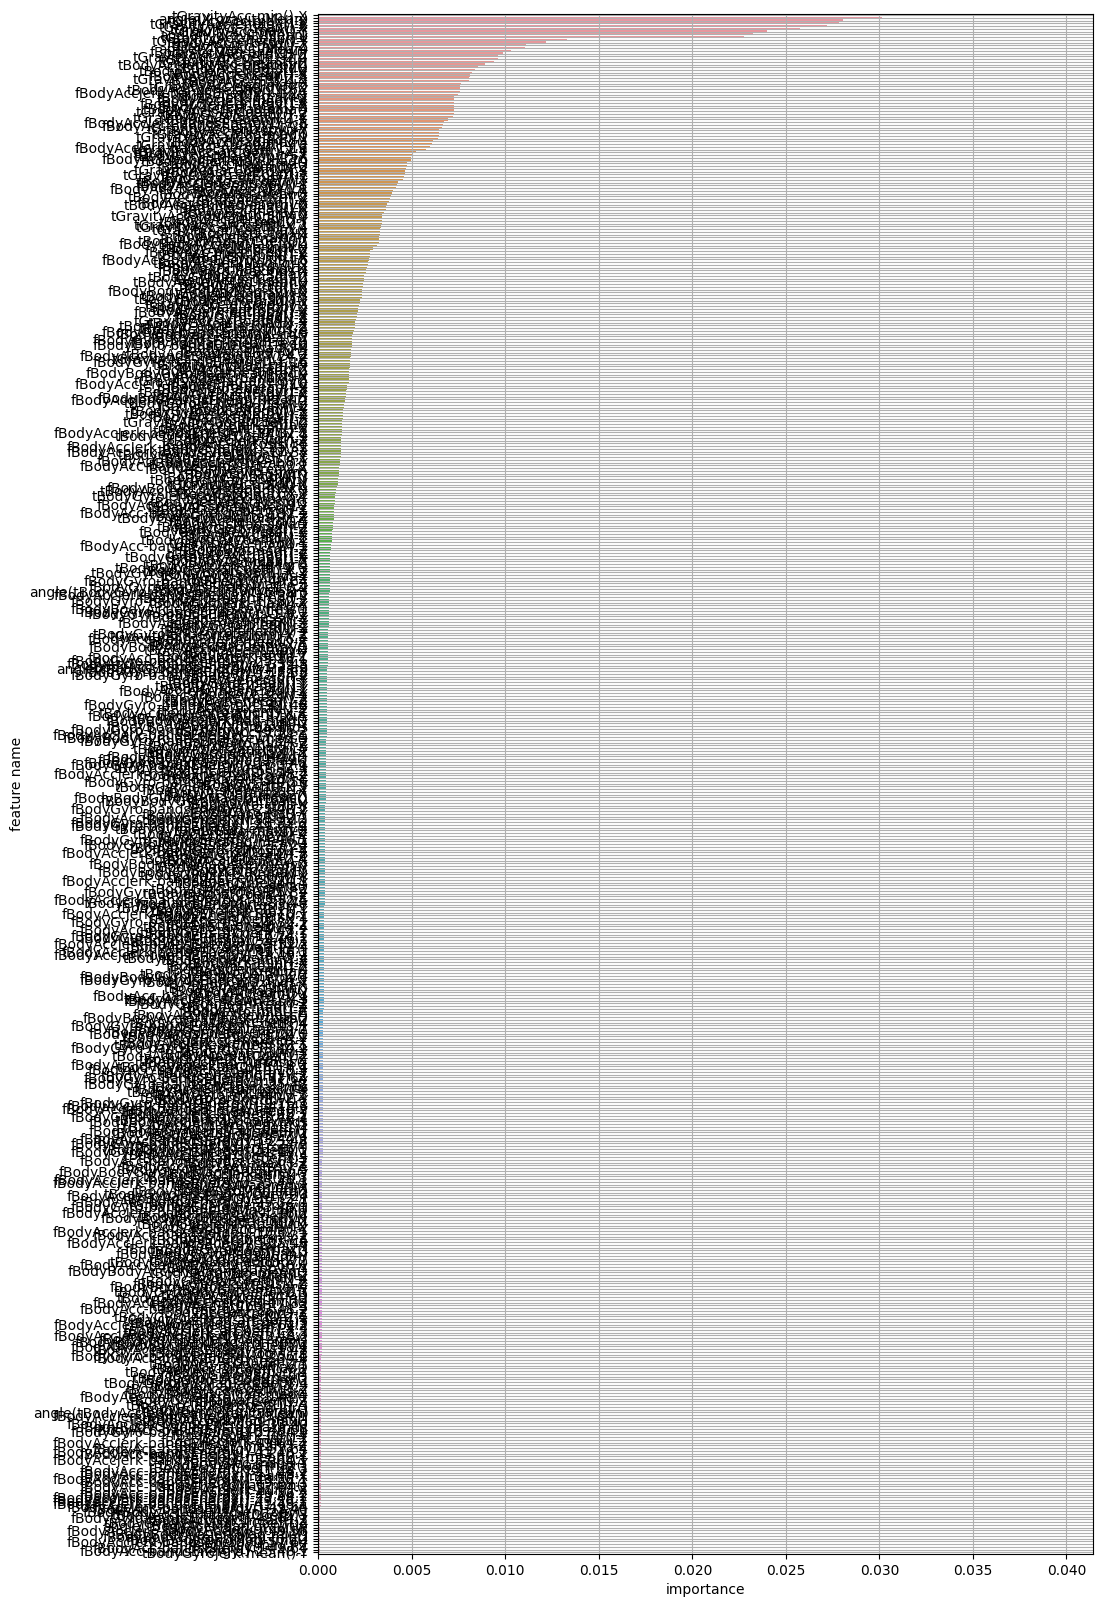

In [20]:
plot_feature_importance(rf.feature_importances_, x.columns)

### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

In [21]:
df = pd.DataFrame(rf.feature_importances_, x.columns, columns=['FI']).sort_values('FI', ascending=False)

In [22]:
print(df.index[0], df.index[-1])

tGravityAcc-min()-X tBodyGyroJerk-mean()-Y


<Axes: xlabel='tBodyGyroJerk-mean()-Y', ylabel='Density'>

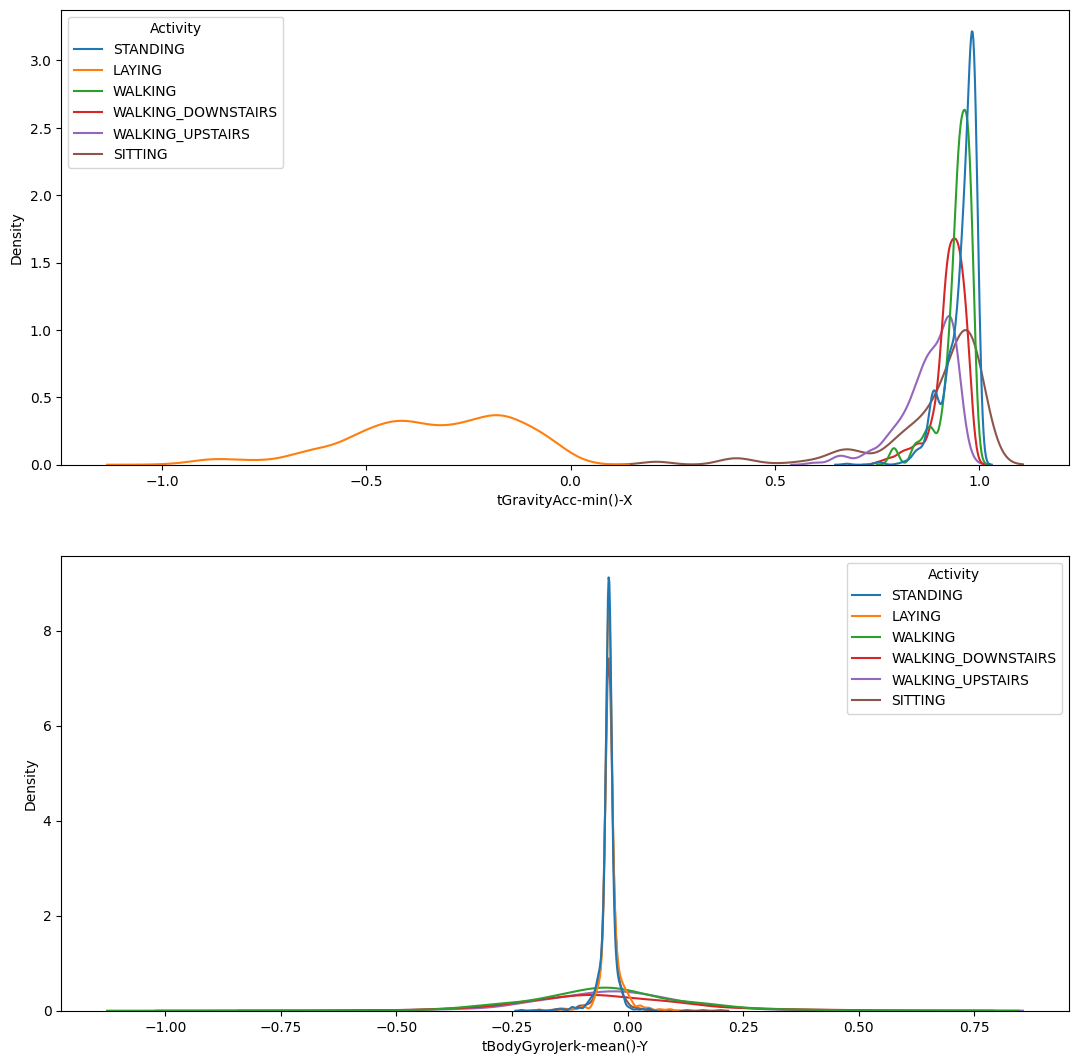

In [23]:
plt.figure(figsize=(13,13))
plt.subplot(2,1,1)
sns.kdeplot(data=data, x='tGravityAcc-min()-X', hue='Activity')
plt.subplot(2,1,2)
sns.kdeplot(data=data, x='tBodyGyroJerk-mean()-Y', hue='Activity')

### (3) feature 그룹별 분석

* **세부 요구사항**
    - 제공된 features.csv 에는 feature에 대한 계층구조를 정리해 놓았습니다.
    - features와 변수중요도 결과를 merge 하시오.
    - sensor 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석을 수행 하시오.
    - sensor + agg 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석을 수행 하시오. 


In [24]:
df = df.reset_index()
df.columns=['feature_name', 'FI']

In [25]:
df = pd.merge(df, features)

In [26]:
df.groupby('sensor').sum().sort_values('FI',ascending=False)

<ipython-input-26-ae6f15647747>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('sensor').sum().sort_values('FI',ascending=False)


,FI
sensor,
tGravityAcc,0.341200
fBodyAccJerk,0.104958
fBodyAcc,0.083109
fBodyGyro,0.071974
tBodyAccJerk,0.066593
angle,0.065863
tBodyAcc,0.044715
fBodyAccMag,0.043553
tBodyGyroJerk,0.034074


In [27]:
df.groupby(['sensor','agg']).sum()

<ipython-input-27-c7c415a4da18>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['sensor','agg']).sum()


FI
sensor         agg                       
angle          X                 0.030140
               Y                 0.023252
               Z                 0.011073
               tBodyAccJerkMean  0.000162
               tBodyAccMean      0.000116
...                                   ...
tGravityAccMag max()             0.003329
               mean()            0.000371
               min()             0.000142
               sma()             0.001686
               std()             0.009602

[221 rows x 1 columns]

## 4.데이터 분석 : 미션2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* 1) Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다. 
* 2) Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다. 
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 targe을 추가하여 EDA를 수행해 봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_dynamic 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_dynamic 추가

In [28]:
data['is_dynamic'] = data['Activity']

In [29]:
dynamic = {'STANDING':0, 'SITTING':0, 'LAYING':0,
           'WALKING':1, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':1}
data['is_dynamic'] = data['is_dynamic'].map(dynamic)

#### 2) 기본모델 생성

In [30]:
X_train, X_val, y_train, y_val = train_test_split(x, data['is_dynamic'], test_size=0.25, random_state=1)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((4410, 561), (1471, 561), (4410,), (1471,))

In [31]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       798
           1       1.00      1.00      1.00       673

    accuracy                           1.00      1471
   macro avg       1.00      1.00      1.00      1471
weighted avg       1.00      1.00      1.00      1471



#### 3) 변수중요도 상위 5개 분석

In [32]:
pd.DataFrame(rf.feature_importances_, x.columns, columns=['FI']).sort_values('FI', ascending=False)[:5]

,FI
fBodyAccJerk-std()-X,0.059977
fBodyAccJerk-mad()-X,0.054927
fBodyAccJerk-energy()-X,0.045019
tBodyAccJerk-mad()-X,0.044972
tBodyGyroJerk-iqr()-Z,0.044893


#### 4) feature 그룹별 분석

In [33]:
fi = pd.DataFrame(rf.feature_importances_, x.columns, columns=['FI']).sort_values('FI', ascending=False).reset_index()
fi.columns = ['feature_name', 'FI']
fi_me = pd.merge(fi, features)

In [34]:
fi_me.groupby('sensor').sum().sort_values('FI', ascending=False)

<ipython-input-34-d5f9ba25fb9a>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  fi_me.groupby('sensor').sum().sort_values('FI', ascending=False)


,FI
sensor,
fBodyAccJerk,0.384985
tBodyAccJerk,0.244615
tBodyAccJerkMag,0.119635
fBodyAcc,0.084808
tBodyGyroJerk,0.079726
fBodyBodyAccJerkMag,0.024827
tBodyGyro,0.020161
tBodyGyroJerkMag,0.014977
fBodyGyro,0.010267


In [35]:
fi_me.groupby(['sensor', 'agg']).sum()

<ipython-input-35-862b6eb2367b>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  fi_me.groupby(['sensor', 'agg']).sum()


FI
sensor         agg                       
angle          X                 0.000005
               Y                 0.000027
               Z                 0.000064
               tBodyAccJerkMean  0.000000
               tBodyAccMean      0.000007
...                                   ...
tGravityAccMag max()             0.000000
               mean()            0.000000
               min()             0.000000
               sma()             0.004936
               std()             0.000027

[221 rows x 1 columns]

### (2) 개별 동작 분석 : is_standing


* **세부 요구사항**
    - Target인 Activity를 is_standing 변수로 변경하시오.
        * 값 1 : STANDING
        * 값 0 : 나머지
    - is_standing 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_standing 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_standing 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_standing 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [36]:
def summary(aictivity_name, aictivity):
  global fi
  data[aictivity_name] = data['Activity']
  data[aictivity_name] = data[aictivity_name].apply(lambda x: 1 if x==aictivity else 0)

  X_train, X_val, y_train, y_val = train_test_split(x, data[aictivity_name], test_size=0.25, random_state=1)

  rf.fit(X_train, y_train)
  y_pred = rf.predict(X_val)
  print(classification_report(y_val, y_pred))

  display(pd.DataFrame(rf.feature_importances_, x.columns, columns=['FI']).sort_values('FI', ascending=False)[:5])

  fi = pd.DataFrame(rf.feature_importances_, x.columns, columns=['FI']).sort_values('FI', ascending=False).reset_index()
  a = 'FI_'+str(aictivity)
  fi.columns = ['feature_name', a]
  fi_me = pd.merge(fi, features)

  display(fi_me.groupby('sensor').sum().sort_values(a, ascending=False))
  display(fi_me.groupby(['sensor', 'agg']).sum())

In [37]:
summary('is_standing', "STANDING")

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1192
           1       0.96      0.95      0.95       279

    accuracy                           0.98      1471
   macro avg       0.98      0.97      0.97      1471
weighted avg       0.98      0.98      0.98      1471



,FI
"angle(Y,gravityMean)",0.068782
tGravityAcc-min()-Y,0.057567
tGravityAcc-max()-Y,0.049451
tGravityAcc-mean()-Y,0.046946
tGravityAcc-min()-Z,0.025131


<ipython-input-36-5be240673618>:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  display(fi_me.groupby('sensor').sum().sort_values(a, ascending=False))


,FI_STANDING
sensor,
tGravityAcc,0.375860
angle,0.115213
fBodyGyro,0.111746
fBodyAcc,0.106564
tBodyAcc,0.066773
tBodyGyro,0.060876
tBodyGyroJerk,0.036662
fBodyAccJerk,0.032153
fBodyAccMag,0.025043


<ipython-input-36-5be240673618>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  display(fi_me.groupby(['sensor', 'agg']).sum())


FI_STANDING
sensor         agg                          
angle          X                    0.022713
               Y                    0.068782
               Z                    0.020533
               tBodyAccJerkMean     0.000198
               tBodyAccMean         0.000258
...                                      ...
tGravityAccMag max()                0.002091
               mean()               0.005213
               min()                0.000361
               sma()                0.002384
               std()                0.002379

[221 rows x 1 columns]

In [38]:
# feature importance 데이터프레임 이름 변경 
STANDING = fi

### (3) 개별 동작 분석 : is_sitting


* **세부 요구사항**
    - Target인 Activity를 is_sitting 변수로 변경하시오.
        * 값 1 : SITTING
        * 값 0 : 나머지
    - is_sitting 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_sitting 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_sitting 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_sitting 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [39]:
summary('is_sitting', "SITTING")

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1224
           1       0.97      0.96      0.96       247

    accuracy                           0.99      1471
   macro avg       0.98      0.97      0.98      1471
weighted avg       0.99      0.99      0.99      1471



,FI
tGravityAcc-min()-Y,0.048821
tGravityAcc-mean()-Y,0.043972
tGravityAcc-max()-Y,0.042077
"angle(Y,gravityMean)",0.035790
"angle(X,gravityMean)",0.031620


<ipython-input-36-5be240673618>:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  display(fi_me.groupby('sensor').sum().sort_values(a, ascending=False))


,FI_SITTING
sensor,
tGravityAcc,0.340964
fBodyGyro,0.265837
tBodyGyro,0.096435
angle,0.080364
tBodyGyroJerk,0.072747
fBodyAccJerk,0.060422
fBodyAcc,0.043276
tBodyAcc,0.042426
tBodyAccJerk,0.023469


<ipython-input-36-5be240673618>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  display(fi_me.groupby(['sensor', 'agg']).sum())


FI_SITTING
sensor         agg                         
angle          X                   0.031620
               Y                   0.035790
               Z                   0.010112
               tBodyAccJerkMean    0.000393
               tBodyAccMean        0.000358
...                                     ...
tGravityAccMag max()               0.000489
               mean()              0.000246
               min()               0.000582
               sma()               0.000493
               std()               0.000101

[221 rows x 1 columns]

In [40]:
SITTING = fi

### (4) 개별 동작 분석 : is_laying


* **세부 요구사항**
    - Target인 Activity를 is_laying 변수로 변경하시오.
        * 값 1 : LAYING
        * 값 0 : 나머지
    - is_laying 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_laying 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_laying 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_laying 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [41]:
summary('is_laying', "LAYING")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1199
           1       1.00      1.00      1.00       272

    accuracy                           1.00      1471
   macro avg       1.00      1.00      1.00      1471
weighted avg       1.00      1.00      1.00      1471



,FI
tGravityAcc-min()-X,0.127656
"angle(X,gravityMean)",0.089514
tGravityAcc-max()-X,0.083658
tGravityAcc-energy()-X,0.083351
tGravityAcc-mean()-X,0.082816


<ipython-input-36-5be240673618>:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  display(fi_me.groupby('sensor').sum().sort_values(a, ascending=False))


,FI_LAYING
sensor,
tGravityAcc,0.679362
angle,0.143156
tBodyAcc,0.028159
tBodyGyro,0.027239
fBodyAccJerk,0.023757
fBodyAcc,0.021743
fBodyGyro,0.020778
tBodyGyroJerk,0.019786
tBodyAccJerk,0.016427


<ipython-input-36-5be240673618>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  display(fi_me.groupby(['sensor', 'agg']).sum())


FI_LAYING
sensor         agg                        
angle          X                  0.089514
               Y                  0.039377
               Z                  0.014058
               tBodyAccJerkMean   0.000056
               tBodyAccMean       0.000037
...                                    ...
tGravityAccMag max()              0.000012
               mean()             0.000087
               min()              0.000022
               sma()              0.000013
               std()              0.000021

[221 rows x 1 columns]

In [42]:
LAYING = fi

### (5) 개별 동작 분석 : is_walking


* **세부 요구사항**
    - Target인 Activity를 is_walking 변수로 변경하시오.
        * 값 1 : WALKING
        * 값 0 : 나머지
    - is_walking 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [43]:
summary('is_walking', "WALKING")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1222
           1       1.00      0.98      0.99       249

    accuracy                           1.00      1471
   macro avg       1.00      0.99      0.99      1471
weighted avg       1.00      1.00      1.00      1471



,FI
"fBodyGyro-bandsEnergy()-17,24",0.020426
tBodyAccMag-std(),0.019251
fBodyAccMag-max(),0.018803
fBodyAccMag-mad(),0.018234
"tGravityAcc-arCoeff()-X,1",0.017003


<ipython-input-36-5be240673618>:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  display(fi_me.groupby('sensor').sum().sort_values(a, ascending=False))


,FI_WALKING
sensor,
tGravityAcc,0.155230
fBodyAcc,0.145091
fBodyGyro,0.134486
fBodyAccJerk,0.108541
tBodyGyroJerk,0.088841
fBodyAccMag,0.083615
tBodyAccMag,0.069901
tBodyAccJerk,0.065391
tGravityAccMag,0.062188


<ipython-input-36-5be240673618>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  display(fi_me.groupby(['sensor', 'agg']).sum())


FI_WALKING
sensor         agg                         
angle          X                   0.002280
               Y                   0.001870
               Z                   0.000360
               tBodyAccJerkMean    0.000060
               tBodyAccMean        0.000047
...                                     ...
tGravityAccMag max()               0.003314
               mean()              0.002390
               min()               0.000179
               sma()               0.002247
               std()               0.015061

[221 rows x 1 columns]

In [44]:
WALKING = fi

### (6) 개별 동작 분석 : is_walking_up


* **세부 요구사항**
    - Target인 Activity를 is_walking_up 변수로 변경하시오.
        * 값 1 : WALKING_UPSTAIRS
        * 값 0 : 나머지
    - is_walking_up 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking_up 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking_up 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking_up 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [45]:
summary('is_walking_up', "WALKING_UPSTAIRS")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1244
           1       0.98      1.00      0.99       227

    accuracy                           1.00      1471
   macro avg       0.99      1.00      0.99      1471
weighted avg       1.00      1.00      1.00      1471



,FI
tGravityAcc-min()-Y,0.035265
"tGravityAcc-arCoeff()-Z,1",0.028509
"tGravityAcc-arCoeff()-Z,2",0.023807
"tGravityAcc-arCoeff()-Z,4",0.023372
fBodyAcc-meanFreq()-Z,0.022994


<ipython-input-36-5be240673618>:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  display(fi_me.groupby('sensor').sum().sort_values(a, ascending=False))


,FI_WALKING_UPSTAIRS
sensor,
tGravityAcc,0.273298
fBodyAcc,0.194702
fBodyAccJerk,0.130630
fBodyGyro,0.063024
tBodyAccJerk,0.049901
tBodyAcc,0.045755
tBodyAccJerkMag,0.037171
tBodyGyro,0.029763
tBodyGyroJerk,0.027648


<ipython-input-36-5be240673618>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  display(fi_me.groupby(['sensor', 'agg']).sum())


FI_WALKING_UPSTAIRS
sensor         agg                                  
angle          X                            0.005650
               Y                            0.019103
               Z                            0.001312
               tBodyAccJerkMean             0.000122
               tBodyAccMean                 0.000090
...                                              ...
tGravityAccMag max()                        0.003052
               mean()                       0.002618
               min()                        0.000176
               sma()                        0.003741
               std()                        0.001960

[221 rows x 1 columns]

In [46]:
WALKING_UPSTAIRS = fi

### (7) 개별 동작 분석 : is_walking_down


* **세부 요구사항**
    - Target인 Activity를 is_walking_down 변수로 변경하시오.
        * 값 1 : WALKING_DOWNSTAIRS
        * 값 0 : 나머지
    - is_walking_down 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking_down 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking_down 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking_down 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [47]:
summary('is_walking_down', "WALKING_DOWNSTAIRS")

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1274
           1       0.99      0.93      0.96       197

    accuracy                           0.99      1471
   macro avg       0.99      0.96      0.98      1471
weighted avg       0.99      0.99      0.99      1471



,FI
tBodyAccMag-std(),0.044546
fBodyAccMag-mean(),0.044066
fBodyAccMag-mad(),0.040278
tGravityAccMag-std(),0.038776
tBodyAcc-max()-X,0.034925


<ipython-input-36-5be240673618>:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  display(fi_me.groupby('sensor').sum().sort_values(a, ascending=False))


,FI_WALKING_DOWNSTAIRS
sensor,
fBodyAccMag,0.195048
fBodyAcc,0.169020
tBodyAcc,0.116620
tGravityAccMag,0.114395
tBodyAccMag,0.099873
fBodyAccJerk,0.079710
tGravityAcc,0.047468
fBodyGyro,0.044150
tBodyAccJerk,0.040687


<ipython-input-36-5be240673618>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  display(fi_me.groupby(['sensor', 'agg']).sum())


FI_WALKING_DOWNSTAIRS
sensor         agg                                    
angle          X                              0.002028
               Y                              0.003337
               Z                              0.001893
               tBodyAccJerkMean               0.000073
               tBodyAccMean                   0.000182
...                                                ...
tGravityAccMag max()                          0.011466
               mean()                         0.008925
               min()                          0.000196
               sma()                          0.005165
               std()                          0.038776

[221 rows x 1 columns]

In [48]:
WALKING_DOWNSTAIRS = fi

## 5.특성 중요도 저장하기

* **세부 요구사항**
    - 지금까지 변수 중요도를 다양한 관점에서 뽑고 분석을 해 보았습니다.
        - 관점1 : 6개 행동 구분
        - 관점2 : 동적, 정적 행동 구분
        - 관점3 : Standing 여부 구분
        - 관점4 : Sitting 여부 구분
        - 관점5 : Laying 여부 구분
        - 관점6 : Walking 여부 구분
        - 관점7 : Walking_upstairs 여부 구분
        - 관점8 : Walking_downstairs 여부 구분
    - 모든 관점의 변수 중요도를 하나로 합친 후 저장
        - merge를 이용하여 features와 합칩니다.
        - joblib 패키지의 dump를 이용하여 결과를 저장합니다.

### (1) 하나로 합치기
* 합치기 위해서는 중요도 결과에서 feature_importance 칼럼 이름을 수정해야 합니다.
* pd.merge를 이용해서 하나씩 합치는 작업을 반복 합니다.

In [49]:
names = SITTING, LAYING, WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
df = pd.merge(features, STANDING)
for name in names:
  df = pd.merge(df, name)

In [50]:
df

,sensor,agg,axis,feature_name,FI_STANDING,FI_SITTING,FI_LAYING,FI_WALKING,FI_WALKING_UPSTAIRS,FI_WALKING_DOWNSTAIRS
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000189,0.000139,0.000341,0.000158,0.000187,0.000280
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000363,0.000876,0.000032,0.000286,0.001011,0.000202
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000221,0.000439,0.000085,0.000199,0.000427,0.000367
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.005723,0.001048,0.000638,0.009252,0.003098,0.016120
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.002230,0.000374,0.000064,0.000154,0.000346,0.001014
...,...,...,...,...,...,...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000916,0.000724,0.000098,0.000268,0.000370,0.000486
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.001813,0.001366,0.000016,0.000166,0.000186,0.000252
558,angle,X,gravityMean,"angle(X,gravityMean)",0.022713,0.031620,0.089514,0.002280,0.005650,0.002028
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.068782,0.035790,0.039377,0.001870,0.019103,0.003337


### (2) 저장하기
* joblib.dump를 이용하시오.
* 저장할 파일의 확장자는 보통 .pkl 입니다.

In [51]:
import joblib
joblib.dump(df, 'sensor.pkl')

['sensor.pkl']

In [52]:
joblib.load('sensor.pkl')

,sensor,agg,axis,feature_name,FI_STANDING,FI_SITTING,FI_LAYING,FI_WALKING,FI_WALKING_UPSTAIRS,FI_WALKING_DOWNSTAIRS
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000189,0.000139,0.000341,0.000158,0.000187,0.000280
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000363,0.000876,0.000032,0.000286,0.001011,0.000202
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000221,0.000439,0.000085,0.000199,0.000427,0.000367
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.005723,0.001048,0.000638,0.009252,0.003098,0.016120
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.002230,0.000374,0.000064,0.000154,0.000346,0.001014
...,...,...,...,...,...,...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000916,0.000724,0.000098,0.000268,0.000370,0.000486
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.001813,0.001366,0.000016,0.000166,0.000186,0.000252
558,angle,X,gravityMean,"angle(X,gravityMean)",0.022713,0.031620,0.089514,0.002280,0.005650,0.002028
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.068782,0.035790,0.039377,0.001870,0.019103,0.003337
